# Imports

In [ ]:
import rasterio
import rasterio.warp
from rasterio.warp import transform_geom
import matplotlib
import matplotlib.pyplot as plt
import fiona
import numpy as np
import shapely 
from shapely import Polygon, MultiPolygon 
import json

In [ ]:
from utilities.area import get_density_per_area
from utilities.geojson import filter_features_by_list, get_polygons

## Boundary data
https://www.geoboundaries.org/countryDownloads.html 

https://data.metabolismofcities.org/dashboards/johannesburg/hub/harvesting/852/

United Kingdom

In [ ]:
london_boroughs = [
    'City of London', 'Westminster', 'Kensington and Chelsea', 'Hammersmith and Fulham', 'Wandsworth', 'Lambeth',
    'Southwark', 'Tower Hamlets', 'Hackney', 'Islington', 'Camden', 'Brent', 'Ealing', 'Hounslow', 'Richmond upon Thames',
    'Kingston upon Thames', 'Merton', 'Sutton', 'Croydon', 'Bromley', 'Lewisham', 'Greenwich', 'Bexley', 'Havering',
    'Barking and Dagenham', 'Redbridge', 'Newham', 'Waltham Forest','Haringey', 'Enfield', 'Barnet', 'Harrow',
    'Hillingdon'
]
inner_city_boroughs = [
    'Islington', 'Camden', 'Westminster', 'Southwark', 'Tower Hamlets', 'Hackney', 'Lambeth'
]

In [ ]:
geojson_filepath = 'data/geoBoundaries-GBR-ADM2-all/geoBoundaries-GBR-ADM2.geojson'
with open(geojson_filepath, 'r') as f:
    shape_data = json.load(f)
    
london_borough_features = filter_features_by_list(shape_data, 'shapeName', london_boroughs)
london_borough_polygons = get_polygons(london_borough_features, mainland=True)

France

In [ ]:
paris_departments = [
    'Paris', 'Val-de-Marne', 'Hauts-de-Seine', 'Seine-Saint-Denis'
]

In [ ]:
geojson_filepath = 'data/geoBoundaries-FRA-ADM2-all/geoBoundaries-FRA-ADM2.geojson'
with open(geojson_filepath, 'r') as f:
    shape_data = json.load(f)

In [ ]:
paris_department_features = filter_features_by_list(shape_data, 'shapeName', paris_departments)
paris_department_polygons = get_polygons(paris_department_features, mainland=True)

Manila, Philipines

In [ ]:
manila_divisons = [
    'NCR, City of Manila, First District', 'NCR, Second District', 'NCR, Third District', 'NCR, Fourth District'
]

In [ ]:
geojson_filepath = 'data/geoBoundaries-PHL-ADM2-all/geoBoundaries-PHL-ADM2.geojson'
with open(geojson_filepath, 'r') as f:
    shape_data = json.load(f)

In [ ]:
manila_divison_features = filter_features_by_list(shape_data, 'shapeName', manila_divisons)
print(len(manila_divison_features))
manila_divison_polygons = get_polygons(manila_divison_features, mainland=True)

4


New York, USA

- change second 'Richmond' to 'Richmond, NY'
- change second 'Kings' to 'Kings, NY'

In [ ]:
geojson_filepath = 'data/geoBoundaries-USA-ADM2-all/geoBoundaries-USA-ADM2.geojson'
with open(geojson_filepath, 'r') as f:
    shape_data = json.load(f)

In [ ]:
new_york_counties = ['New York', 'Bronx', 'Kings, NY', 'Queens', 'Richmond, NY']

In [ ]:
new_york_features = filter_features_by_list(shape_data, 'shapeName', new_york_counties)
new_york_polygons = get_polygons(new_york_features) 

Johannesburg

In [ ]:
city_of_joburg_data = fiona.open("data/2018_Regions_CoJ/2018_Regions.shp", "r")
polygons = get_polygons(city_of_joburg_data, identifier='REGION_NAM')
coj_proj = rasterio.warp.transform_geom(
    city_of_joburg_data.crs,
    rasterio.crs.CRS.from_epsg(4326),
    polygons.values()
)
joburg_polygons = dict((name, Polygon(geom['coordinates'][0])) for name, geom in zip(polygons.keys(), coj_proj))

Gaza

In [ ]:
gaza_strip_districts = [
    'Gaza', 'Khan Yunis', 'Rafah', 'North Gaza', 'Deir Al Balah'
]

In [ ]:
geojson_filepath = 'data/geoBoundaries-PSE-ADM2-all/geoBoundaries-PSE-ADM2.geojson'
with open(geojson_filepath, 'r') as f:
    palestine_data = json.load(f)
    
gaza_features = filter_features_by_list(palestine_data, 'shapeName', gaza_strip_districts)
gaza_polygons = get_polygons(gaza_features)

## Plot at origin

<b>Method1</b>

Rough scale correction

$$
\begin{align}
    y &= R\phi \\
    x &= R\lambda \cos(\phi)
\end{align}
$$

<b>Method 2</b>

Correct with locally centered transverse Mercators. See:
- http://pygis.io/docs/d_understand_crs_codes.html

In [ ]:
def scale_correction(polygons):
    long_min, lat_min, long_max, lat_max = MultiPolygon(polygons.values()).bounds
    lat_avg = (lat_max + lat_min) / 2
    long_avg = (long_min + long_max) / 2
    scale = np.cos(lat_avg * np.pi / 180)
    polygons_out = dict()
    origin = np.array((long_avg, lat_avg))
    for name, polygon in polygons.items():
        coords = polygon.exterior.coords - origin
        coords[:, 0] *= scale
        polygons_out[name] = Polygon(coords)
    return polygons_out

In [ ]:
def transverse_mercator_projection(polygons):
    long_min, lat_min, long_max, lat_max = MultiPolygon(polygons.values()).bounds
    long_avg = (long_min + long_max) /2 
    dst_src = {
        'proj': 'tmerc',
        'lat_0': 0,
        'lon_0': long_avg,
        'k': 1/1000, # convert to km
        'x_0': 0,
        'y_0': 0,
        'ellps': 'WGS84',
        'units': 'm',
        'no_defs': True
    }
    src_crs = rasterio.crs.CRS.from_epsg(4326)
    polygons_dst = transform_geom(
        src_crs,
        dst_src,
        polygons.values()
    )
    polygons_dst = [Polygon(geom['coordinates'][0]) for geom in polygons_dst]
    x_min, y_min, x_max, y_max = MultiPolygon(polygons_dst).bounds
    y_mid = (y_min + y_max) / 2
    origin = np.array((0.0, y_mid))
    polygons_out = dict()
    for name, polygon in zip(polygons.keys(), polygons_dst):
        coords = polygon.exterior.coords - origin
        polygons_out[name] = Polygon(coords) 
    return polygons_out

London    : 51.49° 0.6227
Manila    : 14.57° 0.9678
New York  : 40.71° 0.7581
Paris     : 48.85° 0.6580
Gaza      : 31.41° 0.8535


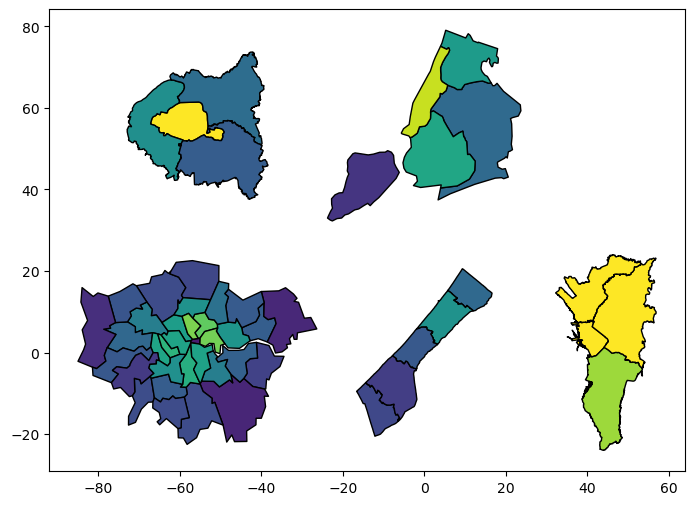

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6));
vmax = 20_000

for region_name, region_polygons, filepath, offset in [
    ('London', london_borough_polygons, 'data/gbr_ppp_2020_constrained.tif', np.array((-0.5, 0))),
    ('Manila', manila_divison_polygons, 'data/phl_ppp_2020_constrained.tif',np.array((0.4, 0.0))),
    #('Joburg', joburg_polygons, 'data/zaf_ppp_2020_constrained.tif',np.array((0.4, 0.0))),
    ('New York', new_york_polygons, 'data/usa_ppp_2020_constrained.tif', np.array((-0.0, 0.5))),
    ('Paris', paris_department_polygons, 'data/fra_ppp_2020_constrained.tif', np.array((-0.5, 0.5))),
    ('Gaza', gaza_polygons, 'data/pse_ppp_2020_constrained.tif', np.array((0, 0))),
    ]:
    patches = []
    colors = []
    long_min, lat_min, long_max, lat_max = MultiPolygon(region_polygons.values()).bounds
    lat_avg = (lat_max + lat_min) /2
    scale = np.cos(lat_avg * np.pi / 180)
    print(f'{region_name:10s}: {lat_avg:.2f}° {scale:.4f}')
    ## Method 1
    #corrected_polygons = scale_correction(region_polygons)
    ## Method 2
    corrected_polygons = transverse_mercator_projection(region_polygons)
    EARTH_RADIUS = 6_378.137 # kilometres. At equator so use WGS-84 semi major axis
    offset = offset * np.pi / 180 * EARTH_RADIUS
    ## both again
    for polygon in corrected_polygons.values(): 
        polygon = polygon.exterior.coords
        polygon += offset
        patches.append(matplotlib.patches.Polygon(polygon))

    with rasterio.open(filepath) as src:
        densities, populations_counts,areas = get_density_per_area(src, region_polygons.values())
    
#     print('-------------' + region_name + '-------------')
#     total_population = 0
#     for (name, density, pop) in zip(region_polygons.keys(), densities, populations_counts):
#         print(f'{name} : {pop:,.0f} people: {density:.2f} people/km^2')
#         total_population += pop
#     print(f'total population: {total_population:,.0f}')

    p = matplotlib.collections.PatchCollection(patches, edgecolor='k')
    colors = densities
    p.set_array(colors)
    p.set_clim(0, vmax)
    axis_image = ax.add_collection(p)
ax.autoscale()
ax.set_aspect('equal')

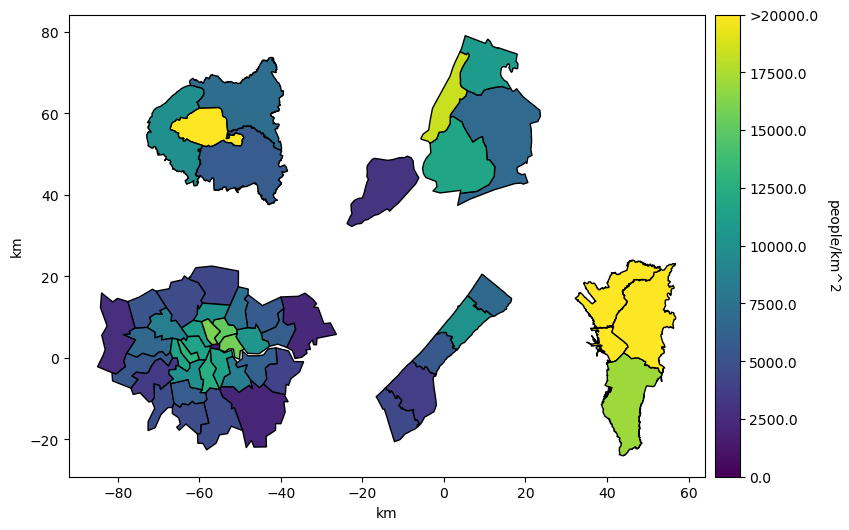

In [ ]:
ax.set_xlabel('km')
ax.set_ylabel('km');

#fig.colorbar(axis_image)
cbar_axis = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.025,ax.get_position().height])
cbar = fig.colorbar(p, cbar_axis)
cbar.set_label('people/km^2', rotation=270, labelpad=15) # density
ticks = cbar.ax.get_yticks()
tick_labels = [f'{x}' for x in ticks]
tick_labels[-1] = '>' + tick_labels[-1]
cbar.ax.set_yticks(ticks);
cbar.ax.set_yticklabels(tick_labels);
fig

Set units if using method 1

In [ ]:
long_min, long_max = ax.get_xlim() 
lat_min, lat_max = ax.get_ylim()

width = (long_max - long_min)
height = lat_max - lat_min

EARTH_RADIUS = 6_378.137 # kilometres. At equator so use WGS-84 semi major axis
y_scale = np.pi / 180 * EARTH_RADIUS
x_scale = np.pi / 180 * EARTH_RADIUS * np.cos(0 * np.pi / 180) # at equator
y_height = (lat_max - lat_min) * y_scale # degree * rad/degree * m
x_width = (long_max - long_min) * x_scale

x_ticklabels = np.arange(0, x_width, 20)
x_ticks = x_ticklabels / x_scale + long_min
y_ticklabels = np.arange(0, y_height, 20)
y_ticks = y_ticklabels / y_scale + lat_min
x_unit = 'km'
y_unit = 'km'

ax.set_xticks(x_ticks, x_ticklabels)
ax.set_xlabel(x_unit)
ax.set_yticks(y_ticks, y_ticklabels)
ax.set_ylabel(y_unit)
ax.set_aspect('equal')
fig

remove units

In [ ]:
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xlabel('')
ax.set_ylabel('')
fig

In [ ]:
fig.savefig('all_densities.png', bbox_inches="tight")